In [1]:
import pandas as pd            
import numpy as np             
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import Imputer
from sklearn.model_selection import cross_val_score
%matplotlib inline

In [2]:
# Read csv
original_data = pd.read_csv('CrowdstormingDataJuly1st.csv')
# Drop meaningless columns, we don't need the whole player name nor the birthday
original_data.drop(['player','birthday'], 1, inplace=True)
# Drop dyads where there are no photoID
original_data.dropna(axis=0, subset=['photoID'], inplace=True)
original_data.drop('photoID', 1, inplace=True)
# Drop dyads where there are no rating
original_data.dropna(axis=0, how='all', subset=['rater1', 'rater2'], inplace=True)
# Drop dyads where there is no position
original_data.dropna(axis=0, how='all', subset=['position'], inplace=True)

In [3]:
# With the interesting data
df = original_data.drop(['refNum', 'refCountry', 'Alpha_3', 'nIAT', 'nExp'], 1)

IAT and Exp are linked to the referee and not directly to the player. The cards are what relates them. So let's try to weight the cards by IAT and Exp.

In [4]:
# IAT 
df['IATYellows'] = df['yellowCards']*df['meanIAT']+df['seIAT']
df['IATYellowReds'] = df['yellowReds']*df['meanIAT']+df['seIAT']
df['IATReds'] = df['redCards']*df['meanIAT']+df['seIAT']
# Exp
df['ExpYellows'] = df['yellowCards']*df['meanExp']+df['seExp']
df['ExpYellowReds'] = df['yellowReds']*df['meanExp']+df['seExp']
df['ExpReds'] = df['redCards']*df['meanExp']+df['seExp']

In [6]:
# Sum for aggregation
dfSumAgg = df[['playerShort', 'games', 'victories', 'ties', 'defeats', 'goals', 'yellowCards','yellowReds', 'redCards',
                'IATYellows', 'IATYellowReds', 'IATReds', 'ExpYellows', 'ExpYellowReds', 'ExpReds']]
aggregatedWithSum = dfSumAgg.groupby('playerShort').sum()

# No sum for aggregation; also we don't take the IAT and Exp scores from the referees
identity = lambda x: x.iloc[0]
dfIdentityAgg = df[['playerShort', 'club', 'leagueCountry', 'height', 'weight', 'position', 
                     'rater1', 'rater2']]
aggregatedWithIdentity = dfIdentityAgg.groupby('playerShort').agg(identity)
dfd = pd.concat([aggregatedWithIdentity, aggregatedWithSum], axis=1)

In [7]:
# Normalize:

# vitories, defeats, ties, goals, cards -> 
#   for each player x: x._/x.games

colsToNorm = ['victories', 'ties', 'defeats', 'goals', 'yellowCards','yellowReds', 'redCards',
             'IATYellows', 'IATYellowReds', 'IATReds', 'ExpYellows', 'ExpYellowReds', 'ExpReds']
ds = []
for c in colsToNorm:
    col = []
    for i in dfd.index:
        col.append(dfd[c].loc[i]/dfd['games'].loc[i])
    ds.append(pd.DataFrame(columns=[c], index=dfd.index, data=col))
    


dfd = pd.concat([pd.concat(ds,axis=1), dfd.drop(colsToNorm, axis=1)] ,axis=1)

In [8]:
# Deal with NaN in weight and height
# There are only few missing data so we can fill them with the mean of the column without
# inducing to much bias in the data

ws = dfd['weight']
meanW = ws.dropna().mean()
dfd['weight'].fillna(meanW, inplace=True)

hs = dfd['height']
meanH = hs.dropna().mean()
dfd['height'].fillna(meanH, inplace=True)

In [9]:
# skin color
colors = np.array([0, 0.25, 0.5, 0.75, 1])
def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return array[idx]

meanColor = (dfd['rater1']+dfd['rater2'])/2

# This is the target/observation
target = meanColor.apply(lambda x: find_nearest(colors, x)).astype('str')
# This is the data
data = dfd.drop(['rater1', 'rater2'], axis=1)
data.head()

,victories,ties,defeats,goals,yellowCards,yellowReds,redCards,IATYellows,IATYellowReds,IATReds,ExpYellows,ExpYellowReds,ExpReds,club,leagueCountry,height,weight,position,games
playerShort,,,,,,,,,,,,,,,,,,,
aaron-hughes,0.377676,0.273700,0.348624,0.013761,0.029052,0.000000,0.000000,0.009982,0.000165,0.000165,0.013617,0.001032,0.001032,Fulham FC,England,182.0,71.0,Center Back,654
aaron-hunt,0.419643,0.217262,0.363095,0.184524,0.125000,0.000000,0.002976,0.042845,0.000064,0.001066,0.048712,0.000292,0.001292,Werder Bremen,Germany,183.0,73.0,Attacking Midfielder,336
aaron-lennon,0.485437,0.235437,0.279126,0.075243,0.026699,0.000000,0.000000,0.008954,0.000090,0.000090,0.011236,0.000498,0.000498,Tottenham Hotspur,England,165.0,63.0,Right Midfielder,412
aaron-ramsey,0.576923,0.161538,0.261538,0.150000,0.119231,0.000000,0.003846,0.041573,0.001334,0.002621,0.056607,0.005409,0.006702,Arsenal FC,England,178.0,76.0,Center Midfielder,260
abdelhamid-el-kaoutari,0.330645,0.322581,0.346774,0.008065,0.064516,0.032258,0.016129,0.022036,0.011387,0.005842,0.023264,0.013306,0.007001,Montpellier HSC,France,180.0,73.0,Center Back,124


In [10]:
# Encode the categorical features
le = preprocessing.LabelEncoder()
clubEncoded = pd.Series(index=data.index, data=le.fit_transform(data.club))
leagueCountreyEncoded = pd.Series(index=data.index, data=le.fit_transform(data.leagueCountry))
positionEncoded = pd.Series(index=data.index, data=le.fit_transform(data.position))

# Dataframe with categorical data encoded as ints
dataEncoded = pd.concat([clubEncoded, positionEncoded, leagueCountreyEncoded], axis=1)
dataEncoded.columns=['club', 'position', 'leagueCountry']

In [465]:
# One hot encoder
enc = preprocessing.OneHotEncoder()
enc.fit(dataEncoded)
oneHotEncodedData = enc.transform(dataEncoded).toarray()
#oneHotEncodedData.astype()
dfEncoded = pd.DataFrame(index=dataEncoded.index, data=oneHotEncodedData).astype(int)

In [466]:
# New data with categorical data encoded
dff = pd.concat([data.drop(['club','position','leagueCountry'], axis=1), dfEncoded], axis=1)

In [467]:
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(dff, target, test_size=0.3, random_state=0)

In [479]:
# Classifier
clf = RandomForestClassifier(n_jobs=-1)

In [480]:
cross_val_score(clf, dff, target).mean()

0.42333882147285401

(array([ 20.,  16.,  11.,  18.,  12.,   4.,   5.,   6.,   4.,   2.,   4.,
          0.,   1.,   1.,   1.,   1.,   2.,   1.,   2.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,
          0.,   0.,   0.,   1.,   0.,   1.,   1.,   1.,   0.,   0.,   0.,
          1.,   1.]),
 array([ 0.        ,  0.00063765,  0.00127531,  0.00191296,  0.00255062,
         0.00318827,  0.00382592,  0.00446358,  0.00510123,  0.00573889,
         0.0063765

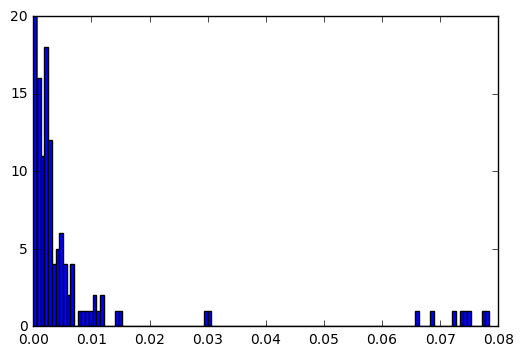

In [487]:
clf.fit(X_train,y_train)
plt.hist(clf.feature_importances_, bins=len(X_train.columns))


# TEST CELLS

In [471]:


d = pd.DataFrame({'A' : ['foo', 'bar', 'foo', 'bar',
                  'foo', 'bar', 'foo', 'foo'],
                  'B' : ['one', 'one', 'two', 'three',
                          'two', 'two', 'one', 'three'],
                  'C' : np.random.randn(8),
                  'D' : np.random.randn(8),
                  'E' : [np.nan,'0','1','0','1','0','1','1'],
                  'F' : [1,2,3,4,5,6,7,8]})
d.set_index('F', inplace=True)

In [472]:
x = []
for c in d['A']:
    x.append(c)
    
x

['foo', 'bar', 'foo', 'bar', 'foo', 'bar', 'foo', 'foo']